In [17]:
# Import common packages
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F, init
import gymnasium as gym
import neurogym as ngym
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm


In [3]:
    

class CTRNN(nn.Module):
    """Continuous-time RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms. 
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()
        
    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.
        
        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
        
        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Continuous time RNN
        self.rnn = CTRNN(input_size, hidden_size, **kwargs)
        
        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

In [4]:
# Canned environment from neurogym
task_name = 'ContextDecisionMaking-v0'
# Importantly, we set discretization time step for the task as well
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}

# Boilerplate gym
env = ngym.make(task_name)

# This is a simple task, the input and output are low-dimensional
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
print('Input size', input_size)
print('Output size', output_size)

Input size 7
Output size 3


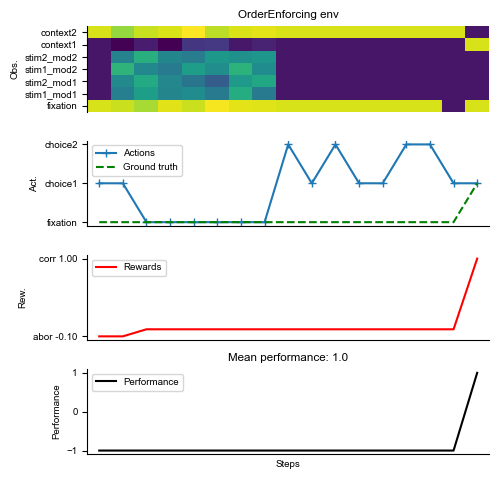

In [5]:
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=0)

In [6]:
# Make supervised dataset, neurogym boilerplate
seq_len = 100
batch_size = 32
dataset = ngym.Dataset(env, batch_size=batch_size, seq_len=seq_len)

# Generate one batch of data when called
inputs, target = dataset()
print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch) =', target.shape)
print('Target are the integers, for example target in the first sequence:')
print(target[:, 0])

Input has shape (SeqLen, Batch, Dim) = (100, 32, 7)
Target has shape (SeqLen, Batch) = (100, 32)
Target are the integers, for example target in the first sequence:
[0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]


In [7]:
import torch.optim as optim
import time

# Instantiate the network and print information
hidden_size = 128
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
print(net)

num_epochs = 3000
def train_model(net, dataset):
    """Simple helper function to train the model.
    
    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair
    
    Returns:
        net: network object after training
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    running_loss = 0
    running_acc = 0
    start_time = time.time()
    # Loop over training batches
    print('Training network...')
    for i in range(num_epochs):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output, _ = net(inputs)
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        running_loss += loss.item()
        if i % 100 == 99:
            running_loss /= 100
            print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, running_loss, time.time() - start_time))
            running_loss = 0
    return net

net = train_model(net, dataset)

RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=7, out_features=128, bias=True)
    (h2h): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Training network...
Step 100, Loss 0.6809, Time 8.0s
Step 200, Loss 0.0374, Time 16.1s
Step 300, Loss 0.0356, Time 24.3s
Step 400, Loss 0.0355, Time 32.0s
Step 500, Loss 0.0352, Time 40.0s
Step 600, Loss 0.0351, Time 47.7s
Step 700, Loss 0.0350, Time 56.4s
Step 800, Loss 0.0350, Time 64.1s
Step 900, Loss 0.0351, Time 71.8s
Step 1000, Loss 0.0349, Time 79.6s
Step 1100, Loss 0.0341, Time 87.3s
Step 1200, Loss 0.0344, Time 95.8s
Step 1300, Loss 0.0410, Time 104.3s
Step 1400, Loss 0.0351, Time 112.2s
Step 1500, Loss 0.0362, Time 124.0s
Step 1600, Loss 0.0353, Time 135.9s
Step 1700, Loss 0.0352, Time 149.1s
Step 1800, Loss 0.0351, Time 162.0s
Step 1900, Loss 0.0351, Time 171.6s
Step 2000, Loss 0.0350, Time 180.2s
Step 2100, Loss 0.0349, Time 189.9s
Step 2200, Loss 0.0350, Tim

In [8]:
import numpy as np
# Reset environment
env = dataset.env
env.reset(no_step=True)

# Initialize variables for logging
perf = 0
activity_dict = {}  # recording activity
trial_infos = {}  # recording trial information

num_trial = 200
for i in range(num_trial):
    # Neurogym boiler plate
    # Sample a new trial
    trial_info = env.new_trial()
    # Observation and groud-truth of this trial
    ob, gt = env.ob, env.gt
    # Convert to numpy, add batch dimension to input
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    
    # Run the network for one trial
    # inputs (SeqLen, Batch, InputSize)
    # action_pred (SeqLen, Batch, OutputSize)
    action_pred, rnn_activity = net(inputs)
    
    # Compute performance
    # First convert back to numpy
    action_pred = action_pred.detach().numpy()[:, 0, :]
    # Read out final choice at last time step
    choice = np.argmax(action_pred[-1, :])
    # Compare to ground truth
    correct = choice == gt[-1]
    
    # Record activity, trial information, choice, correctness
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity
    trial_infos[i] = trial_info  # trial_info is a dictionary
    trial_infos[i].update({'correct': correct})

# Print informations for sample trials
for i in range(5):
    print('Trial ', i, trial_infos[i])
    
print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

Trial  0 {'ground_truth': 2, 'other_choice': 1, 'context': 1, 'coh_0': 50, 'coh_1': 50, 'correct': True}
Trial  1 {'ground_truth': 2, 'other_choice': 2, 'context': 1, 'coh_0': 5, 'coh_1': 5, 'correct': True}
Trial  2 {'ground_truth': 1, 'other_choice': 2, 'context': 1, 'coh_0': 15, 'coh_1': 5, 'correct': False}
Trial  3 {'ground_truth': 2, 'other_choice': 2, 'context': 0, 'coh_0': 15, 'coh_1': 15, 'correct': True}
Trial  4 {'ground_truth': 1, 'other_choice': 1, 'context': 0, 'coh_0': 50, 'coh_1': 15, 'correct': True}
Average performance 0.56


## Original PCA code

Shape of the neural activity: (Time points, Neurons):  (3775, 128)
Shape of the projected activity: (Time points, PCs):  (3775, 2)


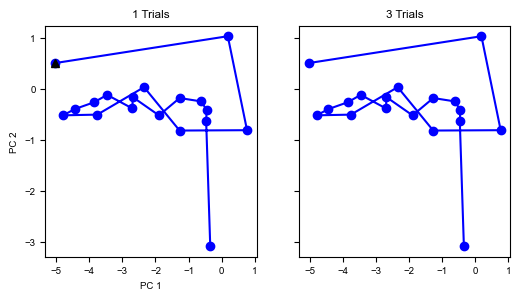

In [9]:
# Project each trial and visualize activity
# Apply PCA, boilerplate sklearn
from sklearn.decomposition import PCA

# Concatenate activity for PCA
activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)

pca = PCA(n_components=2)
pca.fit(activity)  # activity (Time points, Neurons)
activity_pc = pca.transform(activity)  # transform to low-dimension
print('Shape of the projected activity: (Time points, PCs): ', activity_pc.shape)

import matplotlib.pyplot as plt

# Plot all trials in ax1, plot fewer trials in ax2
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))

n_trials = 1
for i in range(n_trials):
    # choose random trial
    j = np.random.randint(0, 100)
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[j])  # (Time points, PCs)

    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'
    
    _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
    if i < 3:
        _ = ax2.plot(activity_pc[:, 
                                 0], activity_pc[:, 1], 'o-', color=color)
        
    # Plot the beginning of a trial with a special symbol
    _ = ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

ax1.set_title('{:d} Trials'.format(n_trials))
ax2.set_title('{:d} Trials'.format(3))
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
plt.show()

In [10]:
activity_dict[0].shape
activity_pc = pca.transform(activity_dict[0])

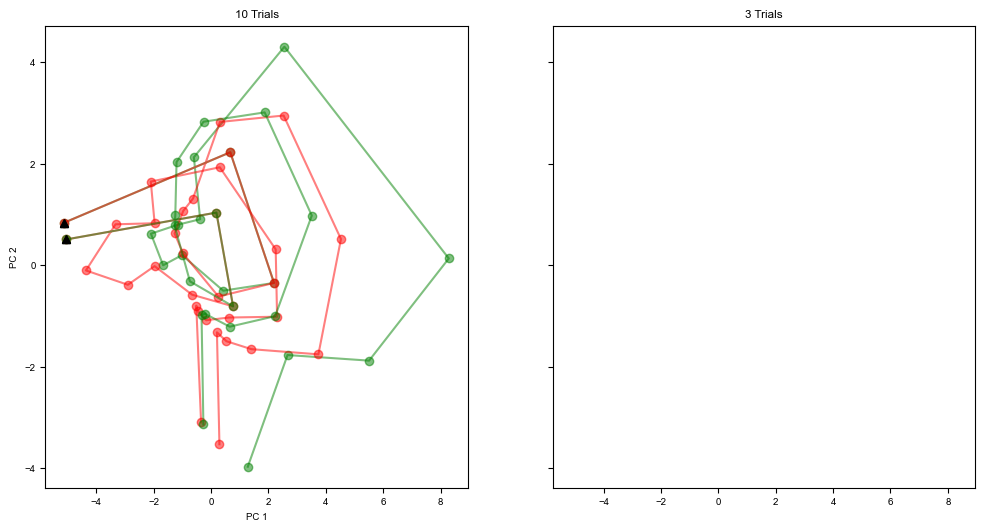

In [11]:
# Project each trial and visualize activity

import matplotlib.pyplot as plt

# Plot all trials in ax1, plot fewer trials in ax2
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))

n_trials = 10
for i in range(n_trials):
    # choose random trial
    j = np.random.randint(0, 100)
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[j])  # (Time points, PCs)

    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 1 else 'green'
    context = trial['context']

    if context==0:
        _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color, alpha=0.5)
        if i < 3:
            _ = ax2.plot(activity_pc[:, 
                                     0], activity_pc[:, 1], 'o-', color=color, alpha=0.5)
            
        # Plot the beginning of a trial with a special symbol
        _ = ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

ax1.set_title('{:d} Trials'.format(n_trials))
ax2.set_title('{:d} Trials'.format(3))
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
plt.show()

## With Gradient Line Plot

Shape of the neural activity: (Time points, Neurons):  (3775, 128)
Shape of the projected activity: (Time points, PCs):  (3775, 2)


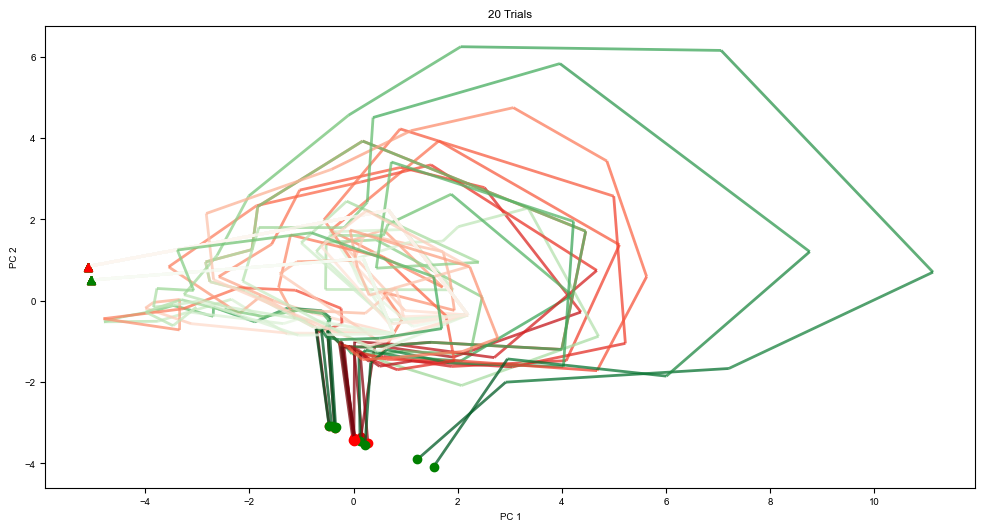

In [12]:
# Apply PCA, boilerplate sklearn
from sklearn.decomposition import PCA

# Concatenate activity for PCA
activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)

pca = PCA(n_components=2)
pca.fit(activity)  # activity (Time points, Neurons)
activity_pc = pca.transform(activity)  # transform to low-dimension
print('Shape of the projected activity: (Time points, PCs): ', activity_pc.shape)

# Project each trial and visualize activity

import matplotlib.pyplot as plt

# Plot all trials in ax1, plot fewer trials in ax2
fig, (ax1) = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(12, 6))

n_trials = 20
for i in range(n_trials):
    # choose random trial
    j = np.random.randint(0, 100)
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[j])  # (Time points, PCs)

    trial = trial_infos[i]
        
    color = 'green' if trial['ground_truth'] == 1 else 'red'
    color_map = 'Greens' if trial['ground_truth'] == 1 else 'Reds'

    
    context = trial['context']

    x = activity_pc[:, 0]
    y = activity_pc[:, 1]
    l = len(x)
    t = np.arange(l)
    
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(t.min(), t.max())
    lc = LineCollection(segments, cmap=color_map, norm=norm, alpha=0.75)  # Set opacity here
    # Set the values used for colormapping
    lc.set_array(t)
    lc.set_linewidth(2)
    line = ax1.add_collection(lc)

    '''
    _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color, alpha=0.5)
    if i < 3:
        _ = ax2.plot(activity_pc[:, 
                                 0], activity_pc[:, 1], 'o-', color=color, alpha=0.5)'''
        
    # Plot the beginning and end of a trial with a special symbol
    _ = ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color=color)
    _ = ax1.plot(activity_pc[l-1, 0], activity_pc[l-1, 1], 'o', color=color)



ax1.set_title('{:d} Trials'.format(n_trials))
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')
plt.show()

## Trying to do 3D PCA analysis

Shape of the neural activity: (Time points, Neurons):  (3775, 128)
Shape of the projected activity: (Time points, PCs):  (3775, 3)


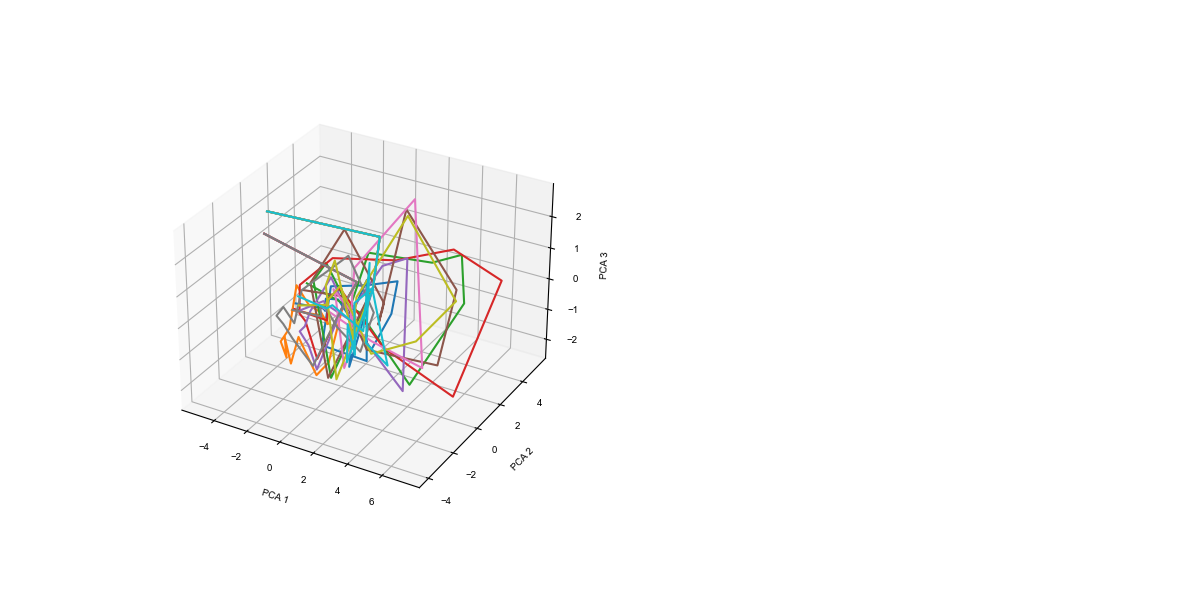

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.decomposition import PCA

# Concatenate activity for PCA
activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)

pca = PCA(n_components=3)  
pca.fit(activity)  
activity_pc = pca.transform(activity)  
print('Shape of the projected activity: (Time points, PCs): ', activity_pc.shape)

# Plot all trials in ax1, plot fewer trials in ax2
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')  
# ax2 = fig.add_subplot(122, projection='3d')  

n_trials = 10
for i in range(n_trials):
    j = np.random.randint(0, 100)
    activity_pc = pca.transform(activity_dict[j])  

    trial = trial_infos[i]
        
    color = 'green' if trial['ground_truth'] == 1 else 'red'
    color_map = 'Greens' if trial['ground_truth'] == 1 else 'YlOrRd'

    x = activity_pc[:, 0]
    y = activity_pc[:, 1]
    z = activity_pc[:, 2]  
    l = len(x)
    t = np.arange(l)

    ax1.plot(x, y, z)
    
ax1.set_xlabel('PCA 1')
ax1.set_ylabel('PCA 2')
ax1.set_zlabel('PCA 3')
plt.show()